# How To Write A Hydro Code

Michael Zingale

There are _many_ methods for solving the equations of hydrodynamics.  We will make some choices right from the start:

  * We will consider **finite-volume methods**.  These are popular in astrophysics because they are based on the integral form of the conservative equations and properly conserve mass, momentum, and energy.
  
  * We will look at a simple 2nd order **method-of-lines** integration.  We do this for simplicity here, and will point out where things are commonly done differently.  This scheme has a much simpler spatial reconstruction and relies on an integrator (like a Runge-Kutta method) to advance in time.
  
  * We will work in 1-d.  
    
Much more in-depth details and derivations are given in my hydro notes available online: https://github.com/Open-Astrophysics-Bookshelf/numerical_exercises

For a greater variety of methods, in 2-d, see the pyro code: https://github.com/python-hydro/pyro2 (ref: [Harpole et al. JOSS](http://joss.theoj.org/papers/10.21105/joss.01265))

## Overview

We'll focus on the Euler equations.  In 1-d, these are:

\begin{align*}
  \frac{\partial \rho}{\partial t} + \frac{\partial (\rho u)}{\partial x} & = 0 \\
  \frac{\partial (\rho u)}{\partial t} + \frac{\partial (\rho u^2 + p)}{\partial x} &= 0 \\
  \frac{\partial (\rho E)}{\partial t} + \frac{\partial (u(\rho E + p))}{\partial x} &= 0 \\
  \end{align*}

This is a set of (hyperbolic) partial differential equations.  To solve these, we need to discretize the equations in both space and time.  We'll use grid-based methods (in addition to the finite-volume method, this can include finite-difference and finite-element methods).  

Our system of equations can be expressed in conservative form:
$$ \frac{\partial U}{\partial t} + \frac{\partial F(U)}{\partial x} = 0$$

In a finite-volume method, we store the state of the fluid in discrete volumes in space, and we can refer to this discretized state with an index.  To see this, we integrate the conservative law system in space over a volume $[x_{i-1/2},x_{i+1/2}]$:
$$\frac{\partial \langle U\rangle_i}{\partial t} = - \frac{F_{i+1/2} - F_{i-1/2}}{\Delta x}$$

This is the form of the equations we will solve.  Here, $\langle U\rangle_i$ represents the average state of the fluid in a volume:
$$\langle U\rangle_i = \frac{1}{\Delta x} \int_{x_{i-1/2}}^{x_{i+1/2}} U(x) dx$$

The state on the grid represents an instance in time.  We evolve the state by computing the fluxes through the volumes.  These fluxes tell us how much the state changes in each volume over some small timestep, $\Delta t$.  

Our code will have the following structure:

  * Create our numerical grid
  
  * Set the initial conditions
  
  * Main timestep evolution loop
  
    * Compute the timestep
    
    * Time-integation loop (depends on the number of stages in the integrator)
  
        * Reconstruct the state to interfaces
    
        * Solve Riemann problem to find the fluxes through the interface
    
        * Do a conservative update of the state to the stage
    
    * Output

## Grid

We'll manage our 1-d grid via a class `FVGrid`.  We will divide the domain into a number of zones (or volumes) that will store the state.  To implement boundary conditions, we traditionally use ghost cells--extra cells added to each end of the domain.

The main information we need to setup the grid are the number of zones in the interior and the number of ghost cells.

In [1]:
import numpy as np

# some global quantities -- usually, we'd put these as members in some simulation class
URHO = 0
UMX = 1
UENER = 2

QRHO = 0
QU = 1
QP = 2

NVAR = 3

gamma = 1.4

C = 0.8

class FVGrid:

    def __init__(self, nx, ng, xmin=0.0, xmax=1.0):

        self.xmin = xmin
        self.xmax = xmax
        self.ng = ng
        self.nx = nx

        # python is zero-based.  Make easy intergers to know where the
        # real data lives
        self.ilo = ng
        self.ihi = ng+nx-1

        # physical coords -- cell-centered
        self.dx = (xmax - xmin)/(nx)
        self.x = xmin + (np.arange(nx+2*ng)-ng+0.5)*self.dx

    def scratch_array(self, nc=1):
        """ return a scratch array dimensioned for our grid """
        if nc == 1:
            return np.zeros((self.nx+2*self.ng), dtype=np.float64)
        else:
            return np.zeros((self.nx+2*self.ng, nc), dtype=np.float64)

    def fill_BCs(self, atmp):
        """ fill all ghost cells with zero-gradient boundary conditions """

        try:
            nc = atmp.shape[1]
        except:
            nc = 1

        if nc == 1:
            atmp[0:self.ilo] = atmp[self.ilo]
            atmp[self.ihi+1:] = atmp[self.ihi]
        else:
            for n in range(nc):
                atmp[0:self.ilo, n] = atmp[self.ilo, n]
                atmp[self.ihi+1:, n] = atmp[self.ihi, n]

## Reconstruction

We need to use the cell-averages to figure out what the fluid state is on the interfaces.  We'll _reconstruct_ the cell-averages as piecewise lines that give us the same average in the zone.  We then follow these lines to the interfaces to define the left and right state at each interface.

In [2]:
def cons_to_prim(grid, U):
    # convert to primitive
    q = grid.scratch_array(nc=NVAR)

    q[:, QRHO] = U[:, URHO]
    q[:, QU] = U[:, UMX]/U[:, URHO]
    q[:, QP] = (U[:, UENER] - 0.5*q[:, QRHO]*q[:, QU]**2)*(gamma - 1.0)
    return q

def states(grid, U):
    q = cons_to_prim(grid, U)

    # construct the slopes
    dq = grid.scratch_array(nc=NVAR)

    for n in range(NVAR):
        # unlimited centered slopes
        dq[grid.ilo-1:grid.ihi+2,n] = 0.5*(q[grid.ilo:grid.ihi+3,n] - q[grid.ilo-2:grid.ihi+1,n])

    # now make the states
    q_l = grid.scratch_array(nc=NVAR)
    q_l[grid.ilo:grid.ihi+2, :] = q[grid.ilo-1:grid.ihi+1, :] + 0.5*dq[grid.ilo-1:grid.ihi+1, :]

    q_r = grid.scratch_array(nc=NVAR)
    q_r[grid.ilo:grid.ihi+2, :] = q[grid.ilo:grid.ihi+2, :] - 0.5*dq[grid.ilo:grid.ihi+2, :]
    
    return q_l, q_r

## Riemann problem and conservative update

We could spend an entire day talking about how to solve the Riemann problem.  The basic idea is that at each interface, we have a left and right state.  Information about the jump across this interface will be carried away from the interface by the 3 hydrodynamic waves ($u$ and $u\pm c$).  The solution to the Riemann problem that we need is the state on the interface--with that we can evaluate the flux through the interface.  

To solve the Riemann problem, we need to know how much each variable changes across each of the three waves.  To complicate matters, the left and right waves can be either shocks or rarefactions.  The middle wave ($u$) is always a contact discontinuity (and of our primitive variables, only $\rho$ jumps across it).

For a gamma-law gas, we can write down analytic expressions for the change in the primitive variables across both a rarefaction and shock.  We can then solve these to find the state inbetween the left and right waves, and then compute the wave speeds to find the solution on the interface.  The exact Riemann solution is somewhat expensive to compute, so we often use approximations.  Here we'll import a solver that uses the _two-shock approximation_.

In [3]:
import riemann

In [4]:
help(riemann.riemann)

Help on function riemann in module riemann:

riemann(q_l, q_r, gamma)
    solve the Riemann problem given left and right primitive variable
    states.  We return the flux



For a method-of-lines approach, we want to just compute the righthand side, $-\partial F/\partial x$

In [5]:
def make_flux_divergence(grid, U):
    
    # get the states
    q_l, q_r = states(grid, U)

    # now solve the Riemann problem
    flux = grid.scratch_array(nc=NVAR)
    for i in range(grid.ilo, grid.ihi+2):
        flux[i, :] = riemann.riemann(q_l[i, :], q_r[i, :], gamma)
        #print("q_l", i, q_l[i,:])
        #print("q_r", i, q_r[i,:])        
        #print("flux:", i, flux[i,:])

    A = grid.scratch_array(nc=NVAR)
    for n in range(NVAR):
        A[grid.ilo:grid.ihi+1, n] = (flux[grid.ilo:grid.ihi+1, n] -
                                     flux[grid.ilo+1:grid.ihi+2, n])/grid.dx

    #print("A", A.min(), A.max())
    return A


## Timestep

In [6]:
def timestep(grid, U):

    # compute the sound speed
    q = cons_to_prim(grid, U)
    c = grid.scratch_array()
    c[grid.ilo:grid.ihi+1] = np.sqrt(gamma *
                                     q[grid.ilo:grid.ihi+1,QP] /
                                     q[grid.ilo:grid.ihi+1,QRHO])

    dt = C * grid.dx / (np.abs(q[grid.ilo:grid.ihi+1, QU]) + c[grid.ilo:grid.ihi+1]).max()
    return dt


## Main driver

In [7]:
def mol_solve(nx):

    grid = FVGrid(nx, 2)
    U = grid.scratch_array(nc=NVAR)

    # setup initial conditions -- this is Sod's problem
    rho_l = 1.0
    u_l = 0.0
    p_l = 1.0
    rho_r = 0.125
    u_r = 0.0
    p_r = 0.1

    idx_l = grid.x < 0.5
    idx_r = grid.x >= 0.5

    U[idx_l, URHO] = rho_l
    U[idx_l, UMX] =  rho_l * u_l
    U[idx_l, UENER] = p_l/(gamma - 1.0) + 0.5 * rho_l * u_l**2

    U[idx_r, URHO] = rho_r
    U[idx_r, UMX] =  rho_r * u_r
    U[idx_r, UENER] = p_r/(gamma - 1.0) + 0.5 * rho_r * u_r**2

    t = 0.0
    tmax = 0.2
    
    while t < tmax:

        # compute the timestep
        dt = timestep(grid, U)

        if t + dt > tmax:
            dt = tmax - t

        print(t, dt, U.max())
        # second-order RK integration
        grid.fill_BCs(U)
        k1 = make_flux_divergence(grid, U)

        U_tmp = grid.scratch_array(nc=NVAR)
        for n in range(NVAR):
            U_tmp[:, n] = U[:, n] + 0.5 * dt * k1[:, n]

        grid.fill_BCs(U_tmp)
        k2 = make_flux_divergence(grid, U_tmp)

        for n in range(NVAR):
            U[:, n] += dt * k2[:, n]

        t += dt

    return U

## Example: Sod's problem

In [11]:
U = mol_solve(128)

0.0 0.005282214092053229 2.5000000000000004
0.005282214092053229 0.003007424415625662 2.7223390717148463
0.00828963850767889 0.002968045701951156 2.6231211823018787
0.011257684209630046 0.002967415388427529 2.6493679906613723
0.014225099598057575 0.002971174821318249 2.648012218201317
0.017196274419375823 0.0028566620060809875 2.643292482330079
0.02005293642545681 0.0028388784258086635 2.646382738868797
0.02289181485126547 0.0028450123418080433 2.636815156396104
0.025736827193073516 0.0027863596035806264 2.6439093714754964
0.02852318679665414 0.0028280888210309957 2.6347770690671615
0.03135127561768514 0.002775920696057346 2.6404361466054023
0.03412719631374248 0.002778637518814438 2.6336539881820893
0.03690583383255692 0.0027850858444235394 2.6368457742798332
0.039690919676980456 0.002768755894162499 2.6330629705100925
0.042459675571142955 0.002800092089491713 2.633267095425175
0.045259767660634664 0.00278034828676833 2.63230973143988
0.048040115947403 0.002791175558214844 2.629789752

In [12]:
import matplotlib.pyplot as plt

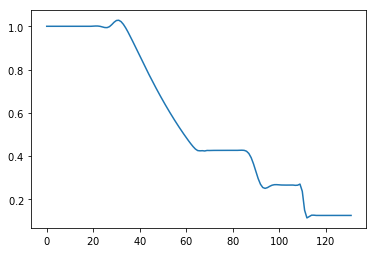

In [13]:
plt.plot(U[:,URHO])